### 📈 Visualizing LFP, MUA, Sniff, and TTL Signals

This script generates time-series plots for electrophysiological recordings, including **Local Field Potentials (LFPs)**, **Multi-Unit Activity (MUA)**, **Sniff Signals**, and **TTL Pulses**. The plots help visualize neural dynamics, respiratory behavior, and event markers across different mice, sessions, and channels.

#### 🗂️ **Data Source:**
The data is loaded from preprocessed `.npy` files:
- **`lfp.npy`**: Local Field Potentials (LFP)
- **`mua.npy`**: Multi-Unit Activity (MUA)
- **`sniff.npy`**: Sniff data (raw)
- **`ttls.npy`**: TTL event markers (raw)

#### 🔍 **Plotting Details:**
- **Number of Segments:** The data is divided into `n_segments` for visualization.  
- **Segment Length:** Each segment is **10 seconds** long.  
- **Sampling Rate:** Signals are sampled at **30 kHz**.  
- **Channels:** LFP and MUA are plotted for each recording channel.

#### 🎨 **Plot Aesthetics:**
- **Consistent Color Palette:**  
  - LFP → Blue (#1f77b4)  
  - MUA → Orange (#ff7f0e)  
  - Sniff → Green (#2ca02c)  
  - TTL → Red (#d62728)  
- **Gridlines:** Added for improved readability.  
- **Shared X-Axis:** All signals are aligned on the time axis (in seconds).  
- **Clean Layout:** Titles, labels, and spacing are optimized for clarity.

#### 💾 **Output Structure:**
The figures are saved in the following format:

```
<fig_dir>
├── <mouse_id>
| ├── <session_id>
| | ├── channel_<channel_num>segment<segment_num>.png
```

Each plot displays:
- **Mouse ID**
- **Session ID**
- **Channel Number**
- **Segment Start Time (in seconds)**

---

This visualization workflow facilitates quick inspection of neural recordings, allowing researchers to identify patterns, artifacts, and key features in the data across multiple sessions and subjects.








In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy import signal
import os

In [6]:
# Specify the directory containing the data
data_dir = r"C:\Users\smearlab\clickbait-ephys\preprocessed_data"

# List of mice to process
mice = ['6001', '6002', '6003']

# Specify the directory to save figures
fig_dir = r"C:\Users\smearlab\clickbait-ephys\figures"
os.makedirs(fig_dir, exist_ok=True)

Processing mouse 6001:  88%|████████▊ | 7/8 [13:49<01:58, 118.52s/session]


ValueError: x and y must have same first dimension, but have shapes (60000,) and (20400,)

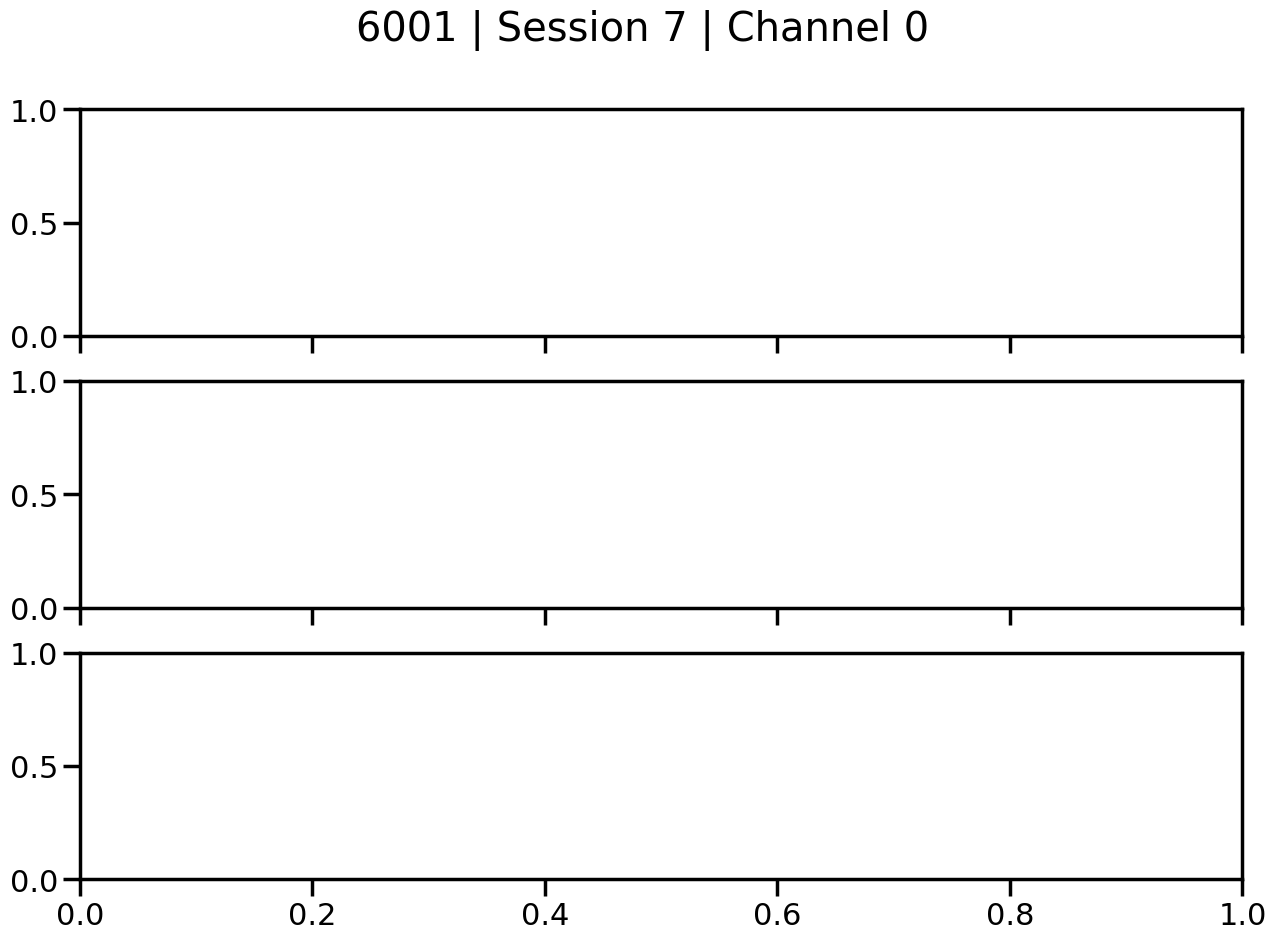

In [ ]:
sns.set_context('poster')

# Constants
n_segments = 10        # Number of segments to plot
length = 2           # Length of each segment (in seconds)
fs = 30000            # Sampling frequency (Hz)
time_axis = np.arange(0, length, 1/fs)  # Time vector for plotting (in seconds)

# Custom color palette
colors = {
    'LFP': '#1f77b4',
    'MUA': '#ff7f0e',
    'Sniff': '#2ca02c',
    'TTL': '#d62728'
}

# Helper function to plot signals
def plot_signals(lfp, theta, mua, sniff,channel, seg, mouse, session, save_path):

    fig, ax = plt.subplots(3, 1, figsize=(15, 10), sharex=True)
    fig.suptitle(f"{mouse} | Session {session} | Channel {channel}")
    signals = {'LFP': lfp, 'MUA': mua, 'Sniff': sniff}
    for i, (label, data) in enumerate(signals.items()):
        if label in ['LFP', 'MUA']:
            ax[i].plot(time_axis, data[channel, seg:seg + length * fs], color=colors[label], linewidth=0.5, alpha =0.7)
            if label == 'LFP':
                ax[i].plot(time_axis, theta[channel, seg:seg + length * fs], color='purple')
        else:
            ax[i].plot(time_axis, data[seg:seg + length * fs], color=colors[label], linewidth=0.8)

        
        # Y-axis labels
        if i in [0, 1]:
            ax[i].set_ylabel(f'{label} (uV)')
        elif i in [2,3]:
            ax[i].set_ylabel(f'{label} (A.U.)')


    ax[-1].set_xlabel('Time (s)')

    # Setting x-ticks and labels
    ax[-1].set_xticks(np.arange(0, length + 0.5, 0.5))
    ax[-1].set_xticklabels(np.arange(seg/fs, seg/fs + length + 0.5, 0.5, dtype=int))
    sns.despine()
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.savefig(save_path, dpi=300)
    plt.close()


# Looping through mice and sessions
sos = signal.butter(4, [4, 12], 'bandpass', fs=30000, output='sos')
for mouse in mice:
    mouse_sessions = os.listdir(os.path.join(data_dir, mouse))
    for session in tqdm(mouse_sessions, desc=f"Processing mouse {mouse}", unit="session"):

        if session in ['0', '1', '2', '3', '4', '5', '6', '7']:
            continue

        # Loading data
        session_path = os.path.join(data_dir, mouse, session)
        lfp = np.load(os.path.join(session_path, 'lfp.npy'), mmap_mode='r', )
        mua = np.load(os.path.join(session_path, 'mua.npy'), mmap_mode='r', )
        sniff = np.load(os.path.join(session_path, 'sniff.npy'), mmap_mode='r', )

        nchannels, num_samples = lfp.shape

        # Create figure directory
        current_fig_dir = os.path.join(fig_dir, mouse, session)
        os.makedirs(current_fig_dir, exist_ok=True)

        # Get equally spaced segment start times
        start_times = np.linspace(0, num_samples - length * fs, n_segments).astype(int)

        # Plotting signals for each channel and segment
        theta = signal.sosfiltfilt(sos, lfp).astype(np.int16)
        for channel in range(nchannels):
            channel_dir = os.path.join(current_fig_dir, f"channel_{channel}")
            os.makedirs(channel_dir, exist_ok=True)
            for seg in start_times:
                save_path = os.path.join(channel_dir, f"segment_{seg}.png")
                plot_signals(lfp, theta, mua, sniff, channel, seg, mouse, session, save_path)